In [10]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np 
from PIL import Image
from torchvision.models import resnet18
import torch.nn as nn
from torch import optim
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import torch 
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_distances


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import euclidean_distances
import shap
from lime import lime_tabular
from typing import Callable, Union, Tuple
import warnings
warnings.filterwarnings('ignore')



In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Télécharger CIFAR-10
train_dataset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
test_dataset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)

# DataLoaders
train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=64, shuffle=True)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=64, shuffle=False)

# Télécharger Fashion MNIST
train_dataset_minst = datasets.FashionMNIST(root='./data', train=True, download=True, transform=preprocess)
test_dataset_minst = datasets.FashionMNIST(root='./data', train=False, download=True, transform=preprocess)

# DataLoaders
train_loader_minst = DataLoader(train_dataset_minst, batch_size=64, shuffle=True)
test_loader_minst = DataLoader(test_dataset_minst, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:39<00:00, 4.35MB/s] 
100%|██████████| 26.4M/26.4M [00:05<00:00, 4.62MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 568kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.19MB/s]


In [12]:
label_names_cifar = test_dataset_cifar.classes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.6639653].


torch.Size([64, 3, 224, 224])


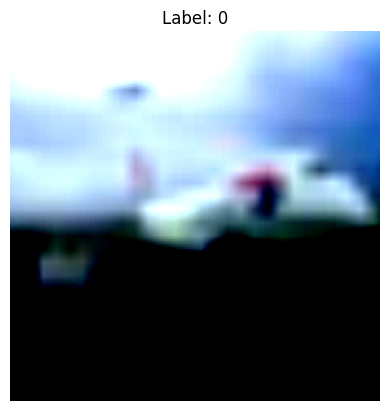

In [13]:
images, labels = next(iter(train_loader_cifar))
print(images.shape)


images = images[:1][0]  # jusqu'à 16 images
labels = labels[:1]

#batch = torch.unsqueeze(img_processed, 0)

img = images.permute(1, 2, 0)  # [H, W, C]
img = img.numpy()

plt.imshow(img)
plt.axis('off')
plt.title(f"Label: {labels[0].item()}")
plt.show()



# Fonctions

In [14]:
def train_model(nb_epoch, model, data_loader, max_batches=None):
    model.train()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()


    for epoch in range(nb_epoch):
        running_loss = 0.0

        for i, (images, labels) in enumerate(data_loader):
            if max_batches is not None and i >= max_batches:
                break

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = loss.item()
            print(f"epoch {epoch} - batch {i}: loss = {running_loss}")

        print(f"Époque {epoch+1}, perte moyenne : {running_loss / (i + 1):.4f}")

        
        
def set_resnet_model(nb_class):
    model = resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc =  nn.Linear(model.fc.in_features, nb_class) 
        
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

def split_data(K,dataset):
    # Initialize KFold
    kfold = KFold(n_splits=K, shuffle=True, random_state=42)

    train_loaders = []
    val_loaders = []

    # Split the dataset into 5 folds
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold}:")
        print(f"Train indices: {train_idx[:5]}")
        print(f"Validation indices: {val_idx[:5]}")

        # Create subsets for training and validation
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        # DataLoaders
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        # Stocker dans les listes
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)


        print(f"Train subset size: {len(train_subset)}, Validation subset size: {len(val_subset)}")
        
    return train_loaders,val_loaders

def predict(model,input):
    with torch.no_grad():
        outputs = model(input)
        _, predicted = torch.max(outputs, 1)
        
    return predicted
    
    

In [42]:
train_data_1 = split_data(4,train_dataset_cifar)[0][0]
model_1 = set_resnet_model(10)
train_model(10,model_1,train_data_1,max_batches=3)

Fold 0:
Train indices: [0 2 3 5 8]
Validation indices: [ 1  4  6  7 13]
Train subset size: 37500, Validation subset size: 12500
Fold 1:
Train indices: [1 2 3 4 5]
Validation indices: [ 0  8 11 17 23]
Train subset size: 37500, Validation subset size: 12500
Fold 2:
Train indices: [0 1 2 4 6]
Validation indices: [ 3  5 14 15 18]
Train subset size: 37500, Validation subset size: 12500
Fold 3:
Train indices: [0 1 3 4 5]
Validation indices: [ 2  9 10 12 16]
Train subset size: 37500, Validation subset size: 12500
epoch 0 - batch 0: loss = 2.389270782470703
epoch 0 - batch 1: loss = 2.275240421295166
epoch 0 - batch 2: loss = 2.3646433353424072
Époque 1, perte moyenne : 0.5912
epoch 1 - batch 0: loss = 2.2423009872436523
epoch 1 - batch 1: loss = 2.119518995285034
epoch 1 - batch 2: loss = 2.275029182434082
Époque 2, perte moyenne : 0.5688
epoch 2 - batch 0: loss = 2.1224355697631836
epoch 2 - batch 1: loss = 2.1273953914642334
epoch 2 - batch 2: loss = 2.0571930408477783
Époque 3, perte moyen

In [43]:
images_test, labels_test = next(iter(test_loader_cifar))
predicted = predict(model_1,images_test)
accuracy_score(predicted, labels_test)

0.390625

In [44]:
labels_test[11]

tensor(9)

# Explanation functions

In [18]:
def extract_datapoint_from_loader(data_loader, index=0):
    """
    Extrait un data point spécifique depuis un DataLoader
    
    Args:
        data_loader: DataLoader contenant vos données
        index: Index du data point à extraire (dans le premier batch)
    
    Returns:
        x_test: Image extraite (numpy array)
        y_test: Label correspondant
    """
    # Récupérer le premier batch
    for batch_idx, (images, labels) in enumerate(data_loader):
        if batch_idx == 0:  # Premier batch seulement
            # Extraire l'image à l'index spécifié
            x_test = images[index].numpy()  # Convertir en numpy
            y_test = labels[index].item()   # Label correspondant
            
            print(f"Shape de x_test: {x_test.shape}")
            print(f"Label y_test: {y_test}")
            
            return x_test, y_test
    
    return None, None

def prepare_data_for_shap(train_loader, num_background=50, num_test=1):
    """
    Prépare les données au bon format pour SHAP
    
    Args:
        train_loader: DataLoader d'entraînement
        num_background: Nombre d'échantillons de fond pour SHAP
        num_test: Nombre d'échantillons de test
    
    Returns:
        x_test: Échantillon(s) de test
        background_data: Données de fond pour SHAP
    """
    all_images = []
    all_labels = []
    
    # Collecter les données
    for images, labels in train_loader:
        all_images.append(images)
        all_labels.append(labels)
        
        # Arrêter si on a assez de données
        if len(torch.cat(all_images, dim=0)) >= num_background + num_test:
            break
    
    # Concaténer
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Séparer background et test
    background_data = all_images[:num_background].numpy()
    x_test = all_images[num_background:num_background + num_test].numpy()
    
    # Si un seul échantillon de test, enlever la dimension batch
    if num_test == 1:
        x_test = x_test[0]
    
    print(f"Shape background_data: {background_data.shape}")
    print(f"Shape x_test: {x_test.shape}")
    
    return background_data
    

In [45]:
x_test = extract_datapoint_from_loader(test_loader_cifar)
background_data = prepare_data_for_shap(train_data_1)

Shape de x_test: (3, 224, 224)
Label y_test: 3
Shape background_data: (50, 3, 224, 224)
Shape x_test: (3, 224, 224)


In [46]:
background_data

array([[[[-1.3472902 , -1.3301654 , -1.3130406 , ..., -1.2102921 ,
          -1.2274169 , -1.2274169 ],
         [-1.3472902 , -1.3301654 , -1.3130406 , ..., -1.1760426 ,
          -1.1931673 , -1.2102921 ],
         [-1.3472902 , -1.3301654 , -1.3130406 , ..., -1.1589178 ,
          -1.1760426 , -1.1931673 ],
         ...,
         [ 0.8446785 ,  0.8446785 ,  0.86180323, ..., -1.2102921 ,
          -1.1246684 , -1.0390445 ],
         [ 0.8446785 ,  0.8446785 ,  0.8446785 , ..., -1.0219197 ,
          -0.95342064, -0.8677969 ],
         [ 0.8446785 ,  0.8446785 ,  0.8446785 , ..., -0.8506721 ,
          -0.78217316, -0.69654936]],

        [[-1.160364  , -1.12535   , -1.107843  , ..., -0.792717  ,
          -0.810224  , -0.84523803],
         [-1.160364  , -1.12535   , -1.107843  , ..., -0.77521   ,
          -0.792717  , -0.827731  ],
         [-1.160364  , -1.1428571 , -1.12535   , ..., -0.757703  ,
          -0.77521   , -0.810224  ],
         ...,
         [ 0.78291327,  0.78291327

In [47]:
# Batch de fond - plusieurs images prétraitées
background = images_test[:10]

# SHAP explainer
explainer = shap.GradientExplainer(model_1, background)

# Explication
#shap_values, indexes = explainer.shap_values(input_tensor)

In [48]:
shap_values = explainer.shap_values(images_test[11].unsqueeze(0)) # attention inuput de la fonction doit être de la dimension d'un batch (shape: [1, 3, 224, 224])

In [49]:
output = model_1(images_test[11].unsqueeze(0))
predicted_class = output.argmax(dim=1).item()

In [50]:
print(shap_values.shape,f'\n{predicted_class }',f'\n{output}','\n', output.shape,'\n',images_test[11].unsqueeze(0).shape)

(1, 3, 224, 224, 10) 
9 
tensor([[-1.0588, -0.0373,  0.0912, -0.7834, -1.2579, -0.5801,  0.0474, -0.9857,
         -0.5086,  1.5479]], grad_fn=<AddmmBackward0>) 
 torch.Size([1, 10]) 
 torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8606442..2.5702832].


<Figure size 800x500 with 0 Axes>

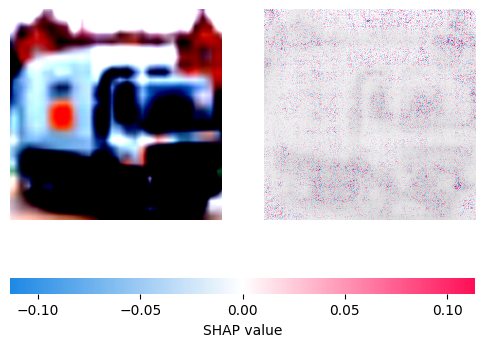

In [51]:
reshaped_shape_values = shap_values[...,8].squeeze(0) 
reshaped_shape_values_hwc = reshaped_shape_values.transpose(1, 2, 0)
image_test_hwc = images_test[11].numpy().transpose(1, 2, 0)


plt.figure(figsize=(8, 5))  # largeur, hauteur en pouces (ajuste si besoin)
#shap.image_plot(shap_values[...,8], images_test[11].unsqueeze(0).cpu().numpy())
shap.image_plot(reshaped_shape_values_hwc, image_test_hwc)


In [26]:
len(images_test[0].shape)

3

In [27]:
def shap_explain(image,model,explainer):
    try: 
        if len(image.shape) == 3 : 
            shap_values = explainer.shap_values(image.unsqueeze(0)) # attention inuput de la fonction doit être de la dimension d'un batch (shape: [1, 3, 224, 224])
            output = model(image.unsqueeze(0))
            predicted_class = output.argmax(dim=1).item()
    
        elif len(image.shape) == 4 : 
            shap_values = explainer.shap_values(image)
            output = model(image)
            predicted_class = output.argmax(dim=1).item()

    except : 
        print('Image dimension failed')
        
    reshaped_shape_values = shap_values[...,predicted_class].squeeze(0) 
    reshaped_shape_values_hwc = reshaped_shape_values.transpose(1, 2, 0)
    image_test_hwc = image.numpy().transpose(1, 2, 0)
    
    return reshaped_shape_values_hwc,image_test_hwc

    
    

# Calcul des distances entre phi 

In [52]:
# Entrainement d'une 2ème fonction f_2 sur un autre split
train_data_2 = split_data(4,train_dataset_cifar)[0][0]
model_2 = set_resnet_model(10)
train_model(10,model_2,train_data_2,max_batches=3)
explainer_2 = shap.GradientExplainer(model_2, background)


Fold 0:
Train indices: [0 2 3 5 8]
Validation indices: [ 1  4  6  7 13]
Train subset size: 37500, Validation subset size: 12500
Fold 1:
Train indices: [1 2 3 4 5]
Validation indices: [ 0  8 11 17 23]
Train subset size: 37500, Validation subset size: 12500
Fold 2:
Train indices: [0 1 2 4 6]
Validation indices: [ 3  5 14 15 18]
Train subset size: 37500, Validation subset size: 12500
Fold 3:
Train indices: [0 1 3 4 5]
Validation indices: [ 2  9 10 12 16]
Train subset size: 37500, Validation subset size: 12500
epoch 0 - batch 0: loss = 2.3939359188079834
epoch 0 - batch 1: loss = 2.354530096054077
epoch 0 - batch 2: loss = 2.3629016876220703
Époque 1, perte moyenne : 0.5907
epoch 1 - batch 0: loss = 2.298394203186035
epoch 1 - batch 1: loss = 2.3301074504852295
epoch 1 - batch 2: loss = 2.3351566791534424
Époque 2, perte moyenne : 0.5838
epoch 2 - batch 0: loss = 2.297125816345215
epoch 2 - batch 1: loss = 2.284653902053833
epoch 2 - batch 2: loss = 2.223785877227783
Époque 3, perte moyenn

In [53]:
x = images_test[11]
phi_x_1 = shap_explain(x,model_1,explainer) # dim : (H, W, C)

In [54]:
phi_x_2 = shap_explain(x,model_2,explainer_2) # dim : (H, W, C)

In [55]:
phi_x_1[0].shape,phi_x_2[0].shape
phi_x_1, phi_x_2 = phi_x_1[0].reshape(1, -1), phi_x_2[0].reshape(1, -1) # Flatten images

euclidean_distances(phi_x_1,phi_x_2),cosine_distances(phi_x_1,phi_x_2)

(array([[4.15178803]]), array([[0.70691618]]))

# Boucle complète d'entrainement et de calcul des phi 

In [58]:
dataset_splited_4fold = split_data(4,train_dataset_cifar)

dico_phi = {}
dico_pred = {}
c = 1
for fold in dataset_splited_4fold[0]:
    print(f'\n split {c} ')
    model = model_1 if c % 2 == 0 else model_2
    train_model(1,model,fold,max_batches=3)
    explain = shap.GradientExplainer(model, background)
    phi_x_fold = shap_explain(x,model,explain)
    dico_phi[c] = phi_x_fold
    
    #predicted = predict(model,x)
    
    output = model(x.unsqueeze(0))
    predicted_class = output.argmax(dim=1).item()
    dico_pred[c] = predicted_class

    c+=1




Fold 0:
Train indices: [0 2 3 5 8]
Validation indices: [ 1  4  6  7 13]
Train subset size: 37500, Validation subset size: 12500
Fold 1:
Train indices: [1 2 3 4 5]
Validation indices: [ 0  8 11 17 23]
Train subset size: 37500, Validation subset size: 12500
Fold 2:
Train indices: [0 1 2 4 6]
Validation indices: [ 3  5 14 15 18]
Train subset size: 37500, Validation subset size: 12500
Fold 3:
Train indices: [0 1 3 4 5]
Validation indices: [ 2  9 10 12 16]
Train subset size: 37500, Validation subset size: 12500

 split 1 
epoch 0 - batch 0: loss = 1.6189006567001343
epoch 0 - batch 1: loss = 1.627139687538147
epoch 0 - batch 2: loss = 1.7924877405166626
Époque 1, perte moyenne : 0.4481

 split 2 
epoch 0 - batch 0: loss = 1.7366793155670166
epoch 0 - batch 1: loss = 1.5746368169784546
epoch 0 - batch 2: loss = 1.7833036184310913
Époque 1, perte moyenne : 0.4458

 split 3 
epoch 0 - batch 0: loss = 1.5448781251907349
epoch 0 - batch 1: loss = 1.6074035167694092
epoch 0 - batch 2: loss = 1.68

In [59]:
for key in dico_phi.keys():
    dico_phi[key] = dico_phi[key][0].reshape(1,-1)
    

keys = list(dico_phi.keys())
distances = {}

c=0
for i in dico_phi.keys():
    c+=1
    n= len(dico_phi.keys())
    for j in range(c,n+1):
        distances[(i,j)] = euclidean_distances(dico_phi[i], dico_phi[j])
        
distances

{(1, 1): array([[0.]]),
 (1, 2): array([[4.24458331]]),
 (1, 3): array([[2.38752643]]),
 (1, 4): array([[4.62155693]]),
 (2, 2): array([[0.]]),
 (2, 3): array([[4.50411467]]),
 (2, 4): array([[2.69234684]]),
 (3, 3): array([[0.]]),
 (3, 4): array([[4.81348256]]),
 (4, 4): array([[0.]])}

# Calcul de S  et du score MeGe:

In [60]:
#label de x = images_test[11] with images_test, labels_test = next(iter(test_loader_cifar))
label_x = labels_test[11]
print('lable de x : ',labels_test[11].item())
# Prédictions de x pour chaque f_i
dico_pred

lable de x :  9


{1: 9, 2: 9, 3: 9, 4: 9}

S={δ(i,j) :f(x)=y∧f (x)=y} (3) S_d={δ(i,j) :f(x)=y⊕f (x)=y} 
xij
∀(i,j) ∈ {1,...,k}2 s.t. i �= j, ∀(x,y) ∈ Vi

In [61]:

c=0
S = {}
S_d  = {}
distances = {}
n= len(dico_phi.keys())
for i in dico_phi.keys():
    c+=1
    for j in range(c,n+1):
        if i ==j : 
            continue
        else : 
            if dico_pred[i] == int(label_x) and dico_pred[j] == int(label_x):
                distances[(i,j)] = euclidean_distances(dico_phi[i], dico_phi[j])
                S[(i,j)] = float(distances[(i,j)])
            else :
                distances[(i,j)] = euclidean_distances(dico_phi[i], dico_phi[j])
                S_d[(i,j)] = float(distances[(i,j)])
                
if len(S) == 0:
    MeGe_x = 0  # or some other appropriate value
else:
    MeGe_x = 1 / (1 + (1 / len(S.keys()))*np.sum(list(S.values())))
        
S,S_d, MeGe_x

({(1, 2): 4.244583306080909,
  (1, 3): 2.387526432260234,
  (1, 4): 4.621556926526988,
  (2, 3): 4.504114674162464,
  (2, 4): 2.692346844879027,
  (3, 4): 4.813482564107139},
 {},
 np.float64(0.20503279829904889))

In [62]:
def compute_ReCo(S, S_d):
    """
    Compute Relative Consistency (ReCo) given:
    - S:   Distances when both models agree (correct predictions)
    - S_d: Distances when models disagree (one correct, one wrong)
    
    Returns:
    - ReCo score (higher = more consistent explanations)
    """
    if len(S) == 0 or len(S_d) == 0:
        return 0.0  # Edge case: no comparable samples
    
    
    all_dists = np.array(list(S.values()) + list(S_d.values()))
    labels = np.array([0]*len(S) + [1]*len(S_d)) 
    
    
    best_balanced_acc = 0
    
    
    for gamma in np.unique(all_dists):
        
        preds = (all_dists <= gamma).astype(int)
        
        tpr = np.sum((preds == 0) & (labels == 0)) / np.sum(labels == 0)
        
        
        tnr = np.sum((preds == 1) & (labels == 1)) / np.sum(labels == 1)
        
     
        balanced_acc = tpr + tnr - 1
        
        if balanced_acc > best_balanced_acc:
            best_balanced_acc = balanced_acc
    
    return max(best_balanced_acc, 0)

ReCo_x = compute_ReCo(S, S_d)
print(f"ReCo for x: {ReCo_x:.4f}")

ReCo for x: 0.0000


# Sanity Checks & Analysis:

Weight randomization:

In [71]:
def compute_pred_phi(model):
    """
    Compute explanation phi and predictions.
    
    Args:
        model: The model to be used for predictions and explanations.
    Returns:
        dico_phi: Dictionary {fold_id: explanation} where explanations are arrays
        dico_pred: Dictionary {fold_id: predicted_class}
    """

    dico_phi = {}
    dico_pred = {}
    c = 1
    for fold in dataset_splited_4fold[0]:
        print(f'\n split {c} ')
        model = model
        train_model(1,model,fold,max_batches=3)
        explain = shap.GradientExplainer(model, background)
        phi_x_fold = shap_explain(x,model,explain)
        dico_phi[c] = phi_x_fold
        
        #predicted = predict(model,x)
        
        output = model(x.unsqueeze(0))
        predicted_class = output.argmax(dim=1).item()
        dico_pred[c] = predicted_class

        c+=1
    return dico_phi, dico_pred


def compute_explanation_distances(dico_phi, dico_pred, label_x):
    """
    Compute explanation distances for MeGe and ReCo metrics.
    
    Args:
        dico_phi: Dictionary {fold_id: explanation} where explanations are arrays
        dico_pred: Dictionary {fold_id: predicted_class}
        label_x: Ground truth label for sample x
    
    Returns:
        S:   Distances when both models agree (correct predictions)
        S_d: Distances when models disagree (one correct, one wrong)

    """
    for key in dico_phi.keys():
        dico_phi[key] = dico_phi[key][0].reshape(1,-1)
    c=0
    S = {}
    S_d  = {}
    distances = {}
    n= len(dico_phi.keys())
    for i in dico_phi.keys():
        c+=1
        for j in range(c,n+1):
            if i ==j : 
                continue
            else : 
                if dico_pred[i] == int(label_x) and dico_pred[j] == int(label_x):
                    distances[(i,j)] = euclidean_distances(dico_phi[i], dico_phi[j])
                    S[(i,j)] = float(distances[(i,j)])
                else :
                    distances[(i,j)] = euclidean_distances(dico_phi[i], dico_phi[j])
                    S_d[(i,j)] = float(distances[(i,j)])
    
                
    return S, S_d

In [72]:
from copy import deepcopy

def randomize_weights(model, noise_std):
    """
    Add Gaussian noise to model weights with standard deviation = noise_std * original_weight_std
    noise_std: 0.05, 0.1, 0.3 as in paper (5%, 10%, 30% degradation)
    """
    with torch.no_grad():
        for param in model.parameters():
            if param.requires_grad:
                std_original = param.data.std().item()
                noise = torch.randn_like(param) * (noise_std * std_original)
                param.data.add_(noise)
    return model

def run_degradation_experiment(original_model, degradation_levels=[0.0, 0.05, 0.1, 0.3]):
    """
    Measure MeGe/ReCo at different degradation levels
    Returns: Dict with {'MeGe': [...], 'ReCo': [...]} per degradation level
    """
    label_x = labels_test[11]
    results = {'MeGe': [], 'ReCo': []}
    
    for level in degradation_levels:
        # Create degraded model
        degraded_model = deepcopy(original_model)
        if level > 0:
            degraded_model = randomize_weights(degraded_model, level)
        
        # Compute explanations and metrics 
        dico_phi, dico_pred = compute_pred_phi(degraded_model)
        S_eq, S_neq = compute_explanation_distances(dico_phi, dico_pred,label_x)
        
        # Calculate metrics
        if len(S) == 0:
            MeGe = 0  # or some other appropriate value
        else:
            MeGe = 1 / (1 + (1 / len(S.keys()))*np.sum(list(S.values())))
        ReCo = compute_ReCo(S_eq, S_neq)  
        
        results['MeGe'].append(MeGe)
        results['ReCo'].append(ReCo)
        
        print(f"Degradation {level*100}%: MeGe={MeGe:.3f}, ReCo={ReCo:.3f}")
    
    return results

# Run degradation experiment
degradation_levels = [0.0, 0.05, 0.1, 0.3]
results = run_degradation_experiment(model_1, degradation_levels)



 split 1 
epoch 0 - batch 0: loss = 1.5149353742599487
epoch 0 - batch 1: loss = 1.6100550889968872
epoch 0 - batch 2: loss = 1.6436117887496948
Époque 1, perte moyenne : 0.4109

 split 2 
epoch 0 - batch 0: loss = 1.4439085721969604
epoch 0 - batch 1: loss = 1.6536672115325928
epoch 0 - batch 2: loss = 1.661722183227539
Époque 1, perte moyenne : 0.4154

 split 3 
epoch 0 - batch 0: loss = 1.669907808303833
epoch 0 - batch 1: loss = 1.545167326927185
epoch 0 - batch 2: loss = 1.6749056577682495
Époque 1, perte moyenne : 0.4187

 split 4 
epoch 0 - batch 0: loss = 1.4969338178634644
epoch 0 - batch 1: loss = 1.4913865327835083
epoch 0 - batch 2: loss = 1.5648057460784912
Époque 1, perte moyenne : 0.3912
Degradation 0.0%: MeGe=0.205, ReCo=0.000

 split 1 
epoch 0 - batch 0: loss = 1.6988513469696045
epoch 0 - batch 1: loss = 1.4967999458312988
epoch 0 - batch 2: loss = 1.4997122287750244
Époque 1, perte moyenne : 0.3749

 split 2 
epoch 0 - batch 0: loss = 1.5637151002883911
epoch 0 - b

Results at different degradation levels:


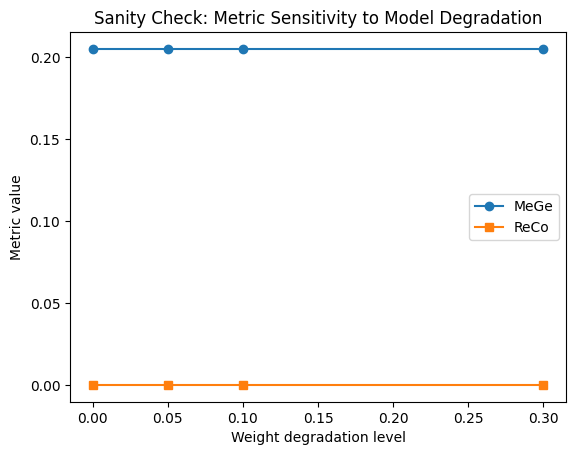

In [73]:
print("Results at different degradation levels:")

# Plot results (as in paper Figure 3)
plt.plot(degradation_levels, results['MeGe'], marker='o', label='MeGe')
plt.plot(degradation_levels, results['ReCo'], marker='s', label='ReCo')
plt.xlabel('Weight degradation level')
plt.ylabel('Metric value')
plt.legend()
plt.title('Sanity Check: Metric Sensitivity to Model Degradation')
plt.show()
